# Example use-case: Cosmological gravitational-wave merger rate density

The original project this codebase was designed for was to calculate the cosmological binary black-hole (BHBH) gravitational-wave merger and supernova transient rate density ([Hendriks et al. 2023](https://doi.org/10.1093/mnras/stad2857)).
 
The following section will flesh out the steps to perform a similar calculation.

Several ingredients are necessary here:
- population-synthesis results that contain BHBH systems
- A cosmological star formation rate density

This convolution is an event-based convolution by integration.

In [1]:
import os
import json
import pkg_resources
import copy
import logging
import h5py

import pandas as pd
import numpy as np
import astropy.units as u

from syntheticstellarpopconvolve import convolve, default_convolution_config, default_convolution_instruction
from syntheticstellarpopconvolve.general_functions import temp_dir, generate_boilerplate_outputfile

TMP_DIR = temp_dir("notebooks", "notebook_example_GW_merger_rate_density", clean_path=True)
VERBOSITY = 0

# The flag below allows the user to run this notebook without the full data or starformation rate. 
FULL_VERSION = os.getenv("EXAMPLE_USECASE_GW_FULL_VERSION", False)

/tmp/ipykernel_289210/2672899259.py:3: DeprecationWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html
  import pkg_resources


Lets start with loading some data and see which metallicities are present. This data is generated by a grid-based population-synthesis evolution at a series of fixed metallicities.

This package contains a minimized version of the data for this usecase, but if the environment variable `EXAMPLE_DATA_USECASE_GW_FILENAME` points to the full dataset it will use that.

In [2]:
# load filename
data_filename = os.getenv('EXAMPLE_DATA_USECASE_GW_FILENAME') if FULL_VERSION else None
example_usecase_GW_events_filename = data_filename if data_filename is not None else pkg_resources.resource_filename(
    "syntheticstellarpopconvolve",
    "example_data/example_data_usecase_gw.h5"
)

# load data
example_usecase_GW_events_data = pd.read_hdf(example_usecase_GW_events_filename,  key='data/combined_dataframes')

if data_filename is not None:
    example_usecase_GW_events_data['delay_time_values_in_years'] = example_usecase_GW_events_data['formation_time_values_in_years']+example_usecase_GW_events_data['merger_time_values_in_years']
if 'delay_time_in_years' in example_usecase_GW_events_data.columns:
    example_usecase_GW_events_data['delay_time_values_in_years'] = example_usecase_GW_events_data['delay_time_in_years']

# query data
example_usecase_GW_events_data=example_usecase_GW_events_data.query('stellar_type_1==14 & stellar_type_2==14')
example_usecase_GW_events_data=example_usecase_GW_events_data.query('comenv_counter==0')

#
log10_metallicity_centers = np.log10(example_usecase_GW_events_data['metallicity'].unique())
stepsize = np.diff(log10_metallicity_centers)

# TODO: use function
log10_bin_edges = np.concatenate([log10_metallicity_centers[:-1]-stepsize/2, log10_metallicity_centers[-2:]+stepsize[:2]/2])

Next up is to set up the star formation info. In this example we use a redshift-based cosmological starformation history, and an accompanying metallicity distribution, both described in [van Son et al. 2023](https://dx.doi.org/10.3847/1538-4357/acbf51). 

The metallicity distribution of [van Son et al. 2023](https://dx.doi.org/10.3847/1538-4357/acbf51) is defined in log Z, and thus we will need to either convert it to a different base, or provide our input metallicity values in log Z as well.

We will first display a high resolution version of this metallicity-dependent star formation rate history, and then configure it to our needs.

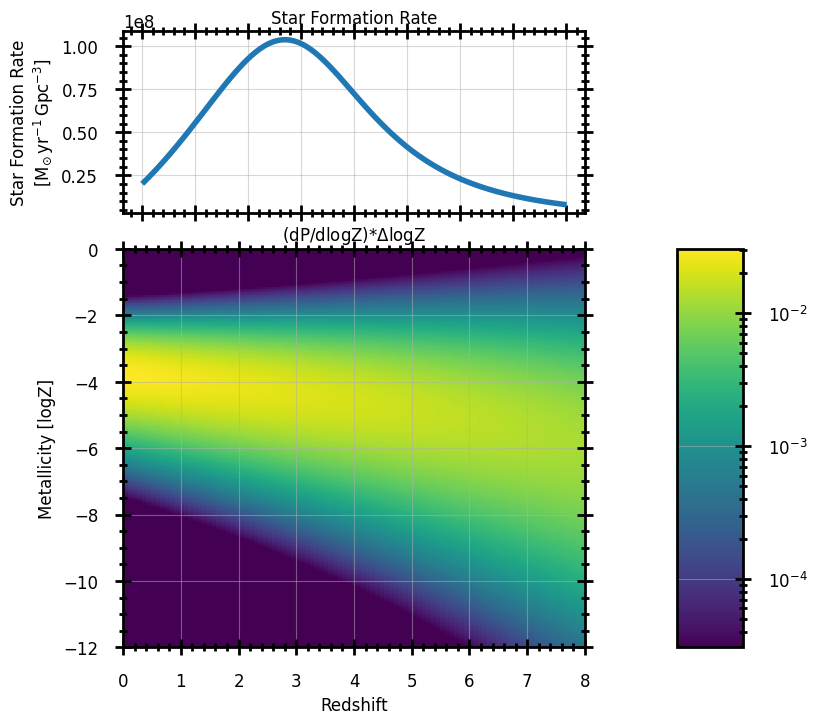

In [10]:
import matplotlib as plt

from syntheticstellarpopconvolve.starformation_rate_distributions import starformation_rate_distribution_vanSon2023
from syntheticstellarpopconvolve.metallicity_distributions import metallicity_distribution_vanSon2022
from syntheticstellarpopconvolve.general_functions import calculate_bincenters, calculate_bin_edges
from syntheticstellarpopconvolve.SFR_dict_plotting_routines import plot_sfr_dict

# Set up redshift bin info
num_redshift_bins = 100
redshift_bin_edges = np.linspace(0, 8, num_redshift_bins); redshift_bin_centers = calculate_bincenters(redshift_bin_edges)

# Set up metallicity bin info
num_metallicity_bins = 200
log_metallicity_bin_edges = np.linspace(-12, 0, num_metallicity_bins); log_metallicity_bin_centers = calculate_bincenters(log_metallicity_bin_edges)

#
sfr = starformation_rate_distribution_vanSon2023(redshift_bin_centers).to(u.Msun/u.yr/u.Gpc**3)

#
dpdlogZ = metallicity_distribution_vanSon2022(
    log_metallicity_centers=log_metallicity_bin_centers,
    redshifts=redshift_bin_centers,
)

high_res_sfr_dict = {
    "redshift_bin_edges": redshift_bin_edges,
    "starformation_rate_array": sfr,
    "metallicity_bin_edges": log_metallicity_bin_edges,
    "metallicity_distribution_array": dpdlogZ,
}

axis_dict = plot_sfr_dict(
    high_res_sfr_dict,
    time_type="redshift",
    metallicity_string="logZ",
    metallicity_distribution_multiply_by_metallicity_bin_sizes=True,
    metallicity_distribution_multiply_by_sfr=False,
    metallicity_distribution_scale="log10",
    metallicity_distribution_cmap=copy.copy(plt.cm.viridis),
    return_axis_dict=True,
    figsize=(8,8),
    fontsize=12,
)

That looks good! Now lets set up our actual SFR dict and lets make sure that the metallicities in our dataset are expressed in log as well. We will let the (log) metallicity values of our data determine the metallicity bin values.

(1e-06, 1)

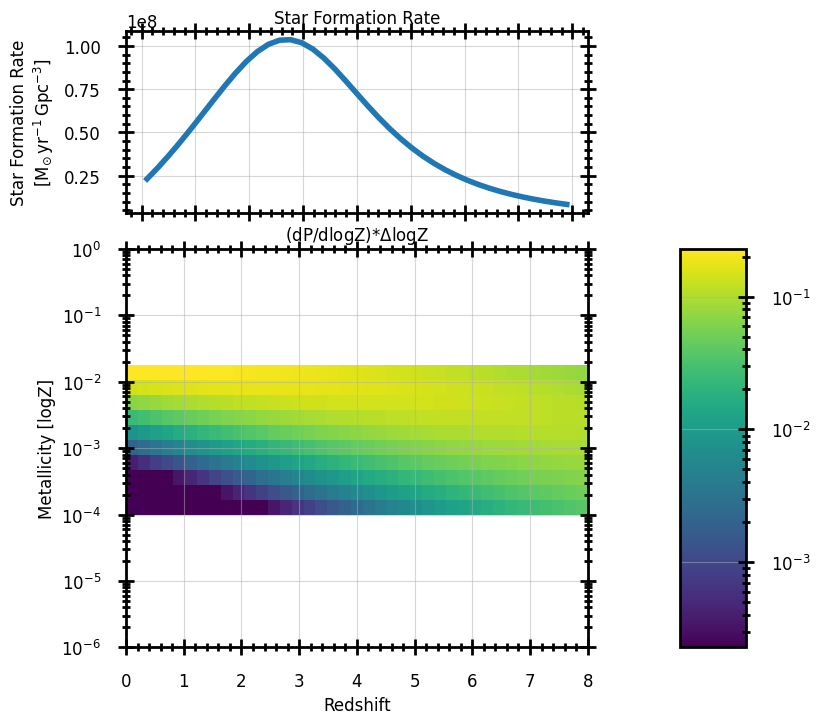

In [4]:
example_usecase_GW_events_data['log_metallicity'] = np.log(example_usecase_GW_events_data['metallicity'])

log_metallicity_bin_centers = np.sort(example_usecase_GW_events_data['log_metallicity'].unique())
log_metallicity_bin_edges = calculate_bin_edges(log_metallicity_bin_centers)

# convert
metallicity_bin_centers = np.exp(log_metallicity_bin_centers)
metallicity_bin_edges = np.exp(log_metallicity_bin_edges)

# Set up redshift bin info
num_redshift_bins = 40
redshift_bin_edges = np.linspace(0, 8, num_redshift_bins); redshift_bin_centers = calculate_bincenters(redshift_bin_edges)

#
dpdlogZ = metallicity_distribution_vanSon2022(
    log_metallicity_centers=log_metallicity_bin_centers,
    redshifts=redshift_bin_centers,
)

#
sfr = starformation_rate_distribution_vanSon2023(redshift_bin_centers).to(u.Msun/u.yr/u.Gpc**3)

#
sfr_dict = {
    "redshift_bin_edges": redshift_bin_edges,
    "starformation_rate_array": sfr,
    "metallicity_bin_edges": metallicity_bin_edges,
    "metallicity_distribution_array": ((1/metallicity_bin_centers) * dpdlogZ),  # We need to transpose!
}

axis_dict = plot_sfr_dict(
    sfr_dict,
    time_type="redshift",
    metallicity_string="logZ",
    metallicity_distribution_multiply_by_metallicity_bin_sizes=True,
    metallicity_distribution_multiply_by_sfr=False,
    metallicity_distribution_scale="log10",
    metallicity_distribution_cmap=copy.copy(plt.cm.viridis),
    return_axis_dict=True,
    figsize=(8,8),
    fontsize=12,
)
axis_dict['ax_mssfr'].set_yscale('log')
axis_dict['ax_mssfr'].set_ylim([0.000001, 1])

Now that we have set up the star formation information and loaded the input data, we can combine everything into the convolution config

In [5]:
# Assign filenames
output_hdf5_filename = os.path.join(TMP_DIR, "output_hdf5.h5")
generate_boilerplate_outputfile(output_hdf5_filename)

# store the data frame in the hdf5file
example_usecase_GW_events_data.to_hdf(output_hdf5_filename, key="input_data/example_GW_merger_rate_density")

print(example_usecase_GW_events_data.columns)

# Some general configuration
convolution_config = copy.copy(default_convolution_config)
convolution_config['logger'].setLevel(logging.WARNING)
convolution_config["output_filename"] = output_hdf5_filename
convolution_config["tmp_dir"] = TMP_DIR
convolution_config["redshift_interpolator_data_output_filename"] = os.path.join(
    TMP_DIR, "interpolator_dict.p"
)
convolution_config["multiply_by_time_binsize"] = False
convolution_config["time_type"] = "redshift"

# convolution instructions
convolution_config["convolution_instructions"] = [
    {
        **default_convolution_instruction,
        "convolution_type": "integrate",
        "input_data_name": "example_GW_merger_rate_density",
        "output_data_name": "intrinsic",
        "data_column_dict": {
            # required
            "normalized_yield": "number_per_solar_mass_values",
            "delay_time": {"column_name": "delay_time_values_in_years", "unit": u.yr},
            "metallicity": "metallicity"
        },
    },
]

# configure the target convolution times. In this case we only want to model the rate at redshift ~0, so its a simple set up
convolution_config["convolution_redshift_bin_edges"] = np.array([0, 0.25])

# store
convolution_config["SFR_info"] = sfr_dict

Index(['uuid', 'mass_1', 'zams_mass_1', 'mass_2', 'zams_mass_2',
       'stellar_type_1', 'stellar_type_2', 'metallicity', 'eccentricity',
       'period', 'zams_period', 'fallback_1', 'fallback_2', 'random_seed',
       'undergone_ppisn_1', 'undergone_ppisn_2', 'comenv_counter',
       'stable_rlof_counter', 'undergone_CE_with_HG_donor',
       'undergone_CE_with_MS_donor', 'formation_time_values_in_years',
       'merger_time_values_in_years', 'number_per_solar_mass_values',
       'local_index', 'delay_time_values_in_years', 'log_metallicity'],
      dtype='object')


In [6]:
# convolve
convolve(config=convolution_config)

[convolution_by_integration.py:33 - convolution_by_integration_post_convolution_hook_wrapper ] 2025-03-30 17:59:11,721: Handling post-convolution function hook call for convolution by integration
[convolve_populations.py:102 - store_convolution_result_entries ] 2025-03-30 17:59:11,743: Storing yield


## Readout and plotting

In [7]:
from syntheticstellarpopconvolve.general_functions import extract_unit_dict, print_hdf5_structure

# we are interested in the primary mass distribution. lets extract the primary mass values:
example_usecase_GW_events_data['primary_mass'] = example_usecase_GW_events_data[['mass_1', 'mass_2']].max(axis=1)
primary_mass_array = example_usecase_GW_events_data['primary_mass'].to_numpy()

# read out content and integrate until today
with h5py.File(convolution_config["output_filename"], "r") as output_hdf5_file:

    # lets inspect the structure within 'output_data'
    print_hdf5_structure(output_hdf5_file, subkey='output_data')

    # lets select the key
    key = "output_data/example_GW_merger_rate_density/intrinsic/convolution_results/0.125/"

    # extract the data and the unit dictionary
    yield_data = output_hdf5_file[key+'yield'][()]
    unit_dict = extract_unit_dict(output_hdf5_file, key)

example_GW_merger_rate_density: Group
example_GW_merger_rate_density/intrinsic: Group
example_GW_merger_rate_density/intrinsic/convolution_results: Group
example_GW_merger_rate_density/intrinsic/convolution_results/0.125: Group
example_GW_merger_rate_density/intrinsic/convolution_results/0.125/yield: Dataset, shape=(33201,), dtype=float64


With the convolution now finished, lets generate a figure that shows the rate of mergers as a function of the primary black hole mass

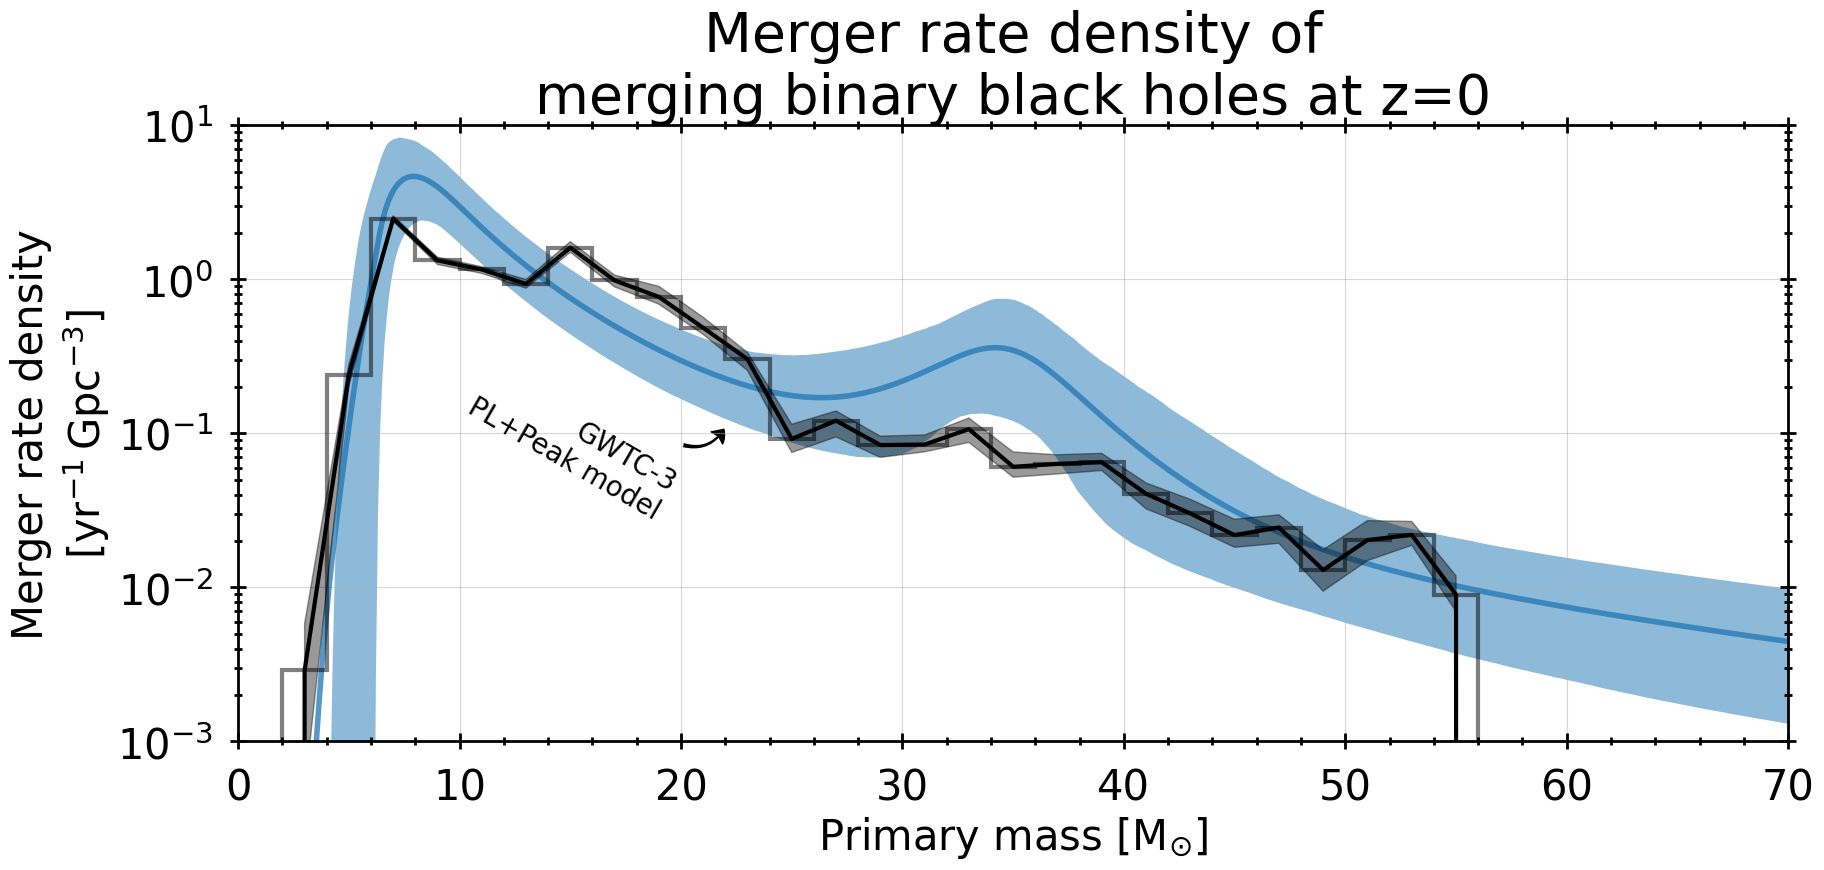

In [16]:
from syntheticstellarpopconvolve.usecase_notebook_utils.usecase_gw_utils import add_confidence_interval_powerlaw_peak_primary_mass, run_bootstrap, plot_bootstrapped_data

primary_mass_bins = np.arange(0, 80, 2)
primary_mass_bin_centers = (primary_mass_bins[1:]+primary_mass_bins[:-1])/2

##################
# Plot data
fig, ax = plt.subplots(figsize=(20,8))

# Plot histogram of primary masses and their associated rates
# ax.hist(primary_mass_array, bins=primary_mass_bins, weights=yield_data, edgecolor='black', alpha=0.7)

# perform bootstrapping of the convolution results
median_percentile_data = run_bootstrap(
    bins=primary_mass_bins,
    bin_centers=primary_mass_bin_centers,
    rates=yield_data,
    masses=primary_mass_array, 
    bootstraps=50,
    verbose=False)

# plot the data 
plot_bootstrapped_data(
    fig=fig,
    ax=ax,
    bin_centers=primary_mass_bin_centers,
    bin_edges=primary_mass_bins,
    median_percentile_data=median_percentile_data,
    label='test',
    color_i="black",
    linestyle_i="solid",
    include_hist_step=True
)

# Add confidence interval of observations (GWTC-3). 
fig, ax = add_confidence_interval_powerlaw_peak_primary_mass(
    fig=fig,
    ax=ax,
    data_root=os.path.join(os.environ["DATAFILES_ROOT"], "GW"),
    fill_between_kwargs={},
    add_text=True,
    redshift=0.2,
)

# Set axis labels and title
ax.set_xlabel('Primary mass [{}]'.format(u.Msun.to_string("latex_inline")))
ax.set_ylabel('Merger rate density\n[{}]'.format(unit_dict['yield'].to_string("latex_inline")))
ax.set_title('Merger rate density of\nmerging binary black holes at z=0')
ax.set_ylim(0.001, 10)
ax.set_xlim(0, 70)
ax.set_yscale('log')

plt.show()

With the full datasets for .. availble on https://zenodo.org/records/8083112, and a better resolved convolution, we can recreate the following figures